# (30) fit iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 1
device = f'cuda:{device_idx}'

## Fit one model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')
cfg_tr['file_name'] = 'patches.npy'

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 'dec_type': 'lin', 
'enc_bias': False, 'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.05}

Trainer:
{'lr': 0.005, 'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0, 'file_name': 'patches.npy'}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

{'file_name': 'patches.npy', 'n_blocks': 100, 'vld_portion': 0.2, 'shift_rescale': True, 'flatten': True}

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  262.7 K   |
|     ———     |    ———     |
|  layers.L_0 |  262.7 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-1_z-[512]_fp_nrm-none_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.1:lin-0.5)_gr(500)_(2024_07_30,14:36)

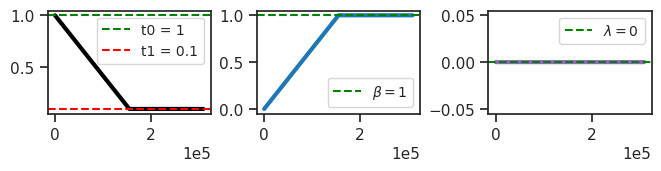

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

### Fit model

In [6]:
tr.train()

epoch # 3000, avg loss: 163.648331: 100%|████████████████████████████████████████████████████| 3000/3000 [1:51:40<00:00,  2.23s/it]


### Loss

In [7]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'][-1]
order = np.argsort(kl_diag)
loss = {
    k: np.mean(v) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{'kl': 32.559624, 'recon': 135.8825, 'nelbo': 168.44212}

### Visualize

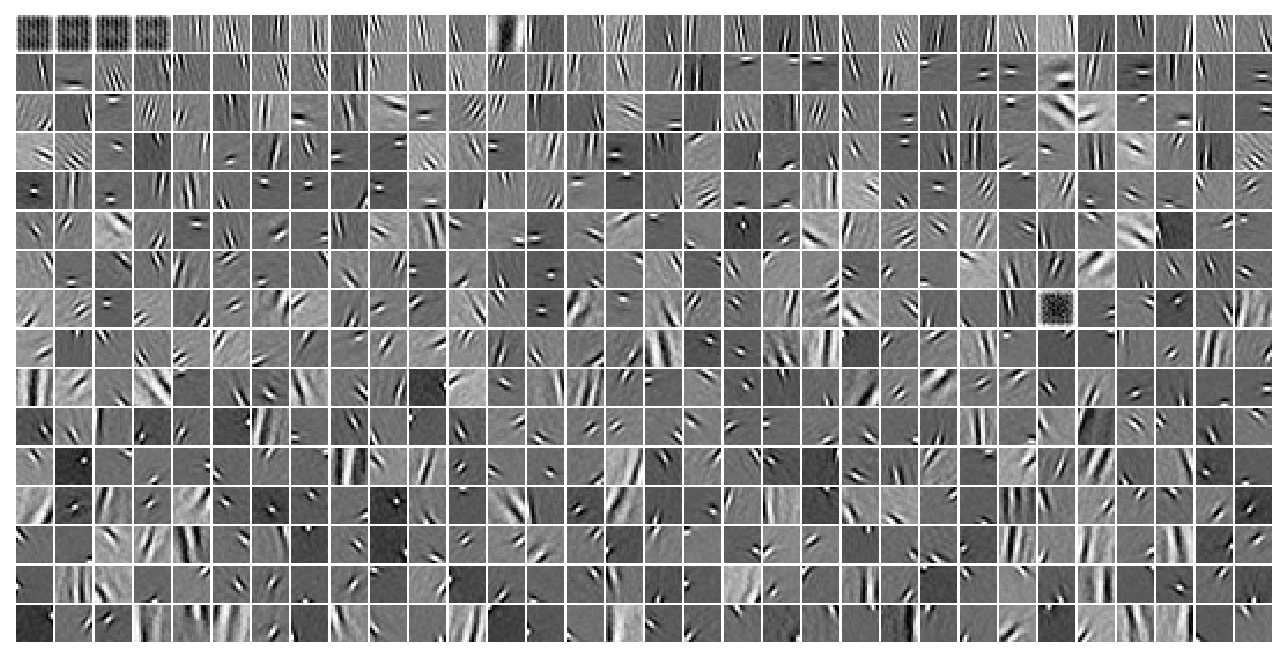

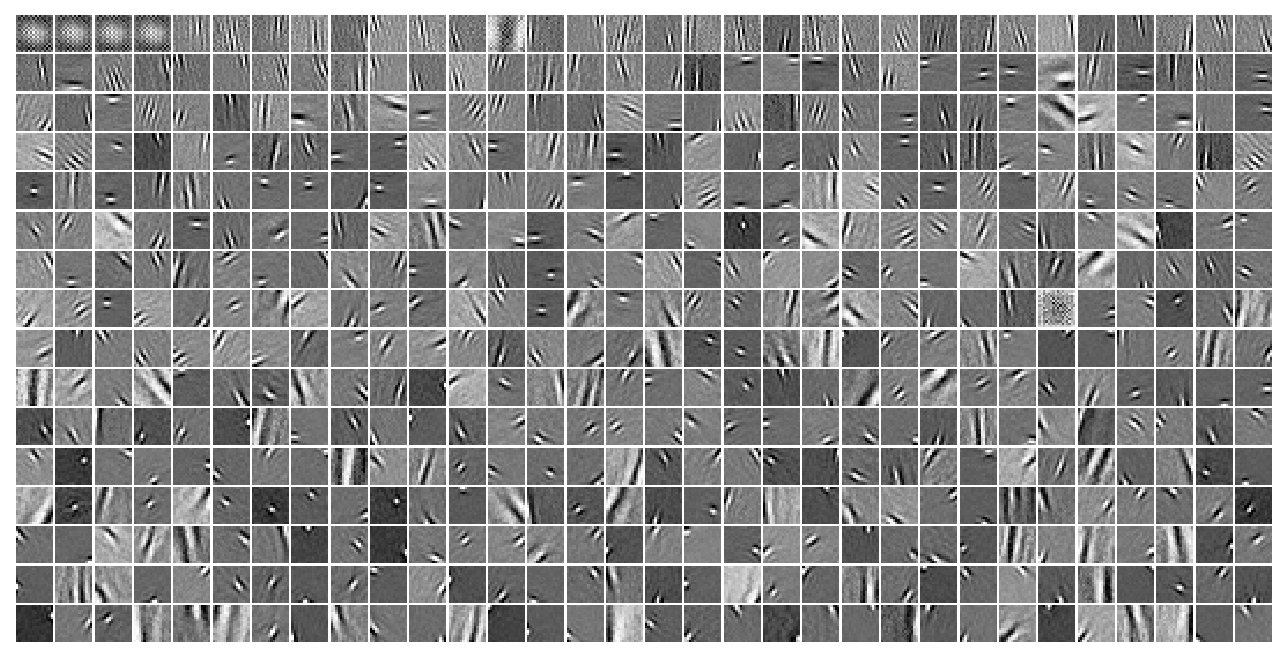

In [9]:
tr.model.show('phi', order=order)
tr.model.show('proj', order=order);

## Load model

In [7]:
root = add_home('Dropbox/chkpts/PoissonVAE')

models2load = {
    'poisson': 'poisson-<lin|lin>-vH16-nrm-none_soft+t0.1_chewie-1_(2024_07_26,18/06)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [8]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 262.7 K

In [13]:
tr = trainers['poisson']
data, loss, etc = tr.validate(full_data=True)
order = np.argsort(loss['kl_diag'])

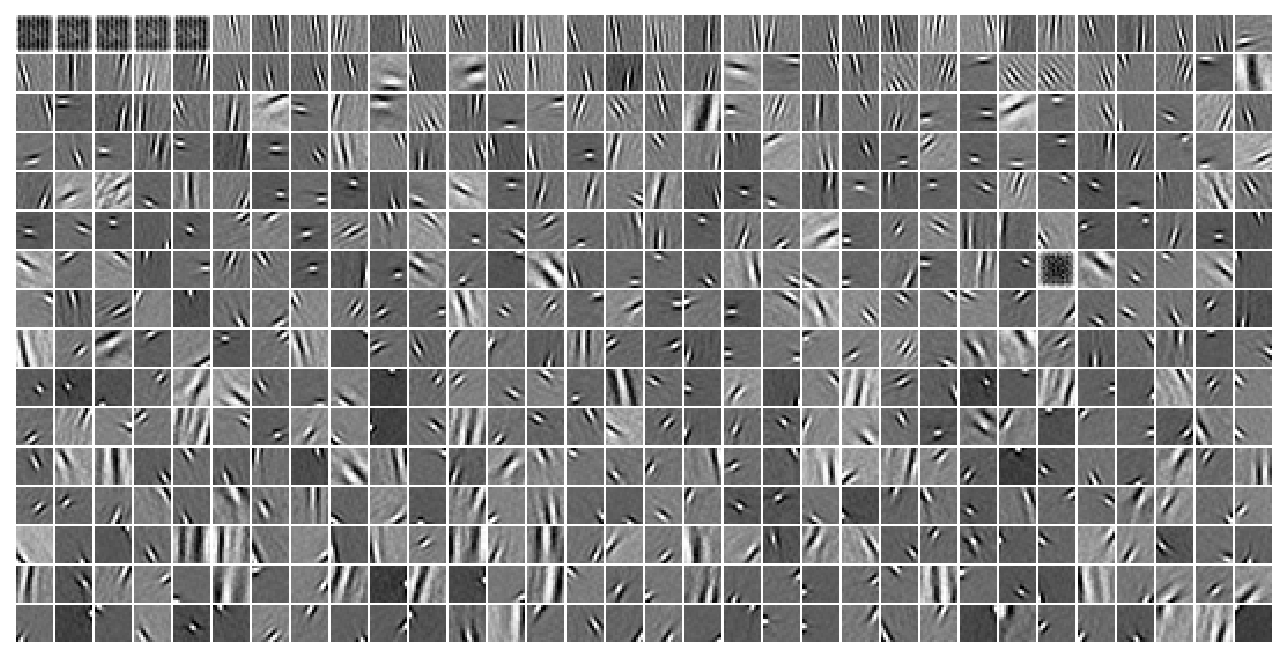

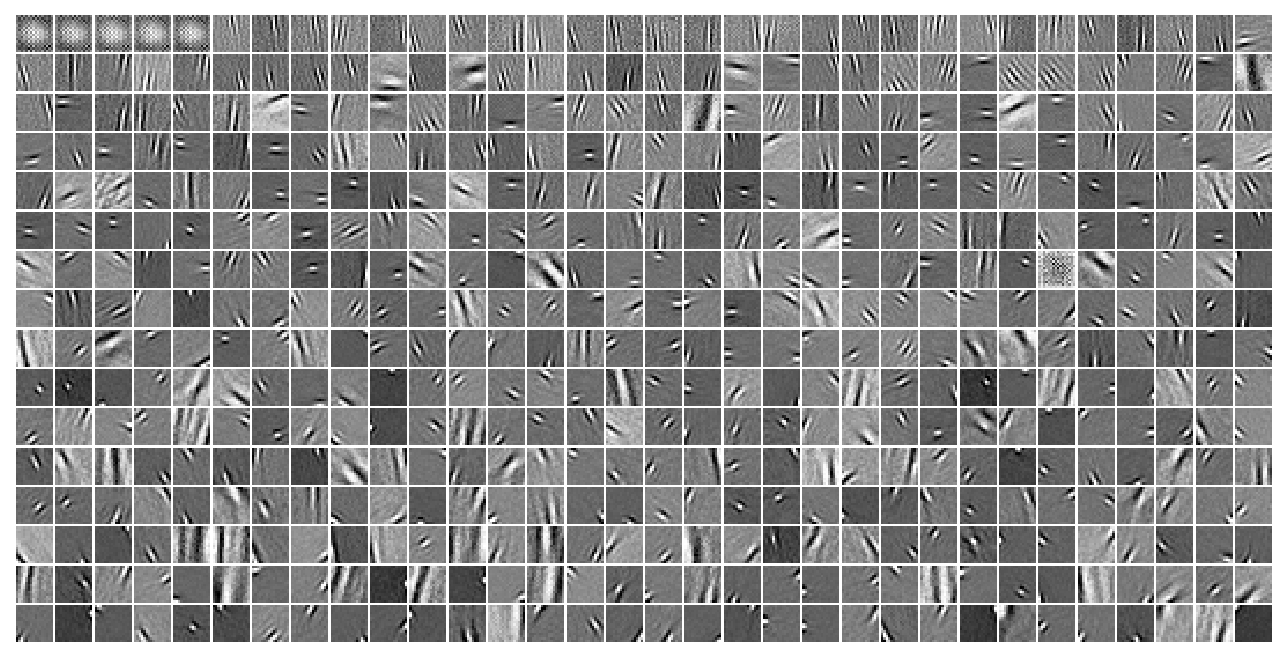

In [16]:
tr.model.show('dec', order=order)
tr.model.show('enc', order=order);